In [1]:
import dawdreamer as daw
from scipy.io import wavfile

import tensorflow as tf
import keras.api._v2.keras as keras
import keras.layers as layers

import random
import os.path

save_path = 'C:/FYP/ml-fm/wavs/'

SAMPLE_RATE = 44100
BUFFER_SIZE = 128
DURATION = 3 # overall duration of each audio file in seconds. This limits the range of attack values that will have an effect on the 
NOTE_DURATION = 3 # duration of midi note on message
START = 0

OUTPUT_PARAMS = 10

SYNTH_PLUGIN = "C:/FYP/vst2 dexed/Dexed.dll"

#import local edited version of spiegelib

from pathlib import Path
import sys

path_root = os.path.abspath('')
sys.path.append(str(path_root))
print(sys.path)

import spiegelib as spgl

['c:\\FYP\\ml-fm', 'c:\\Users\\Max\\miniconda3\\envs\\tf\\python39.zip', 'c:\\Users\\Max\\miniconda3\\envs\\tf\\DLLs', 'c:\\Users\\Max\\miniconda3\\envs\\tf\\lib', 'c:\\Users\\Max\\miniconda3\\envs\\tf', '', 'C:\\Users\\Max\\AppData\\Roaming\\Python\\Python39\\site-packages', 'C:\\Users\\Max\\AppData\\Roaming\\Python\\Python39\\site-packages\\win32', 'C:\\Users\\Max\\AppData\\Roaming\\Python\\Python39\\site-packages\\win32\\lib', 'C:\\Users\\Max\\AppData\\Roaming\\Python\\Python39\\site-packages\\Pythonwin', 'c:\\Users\\Max\\miniconda3\\envs\\tf\\lib\\site-packages', 'c:\\Users\\Max\\miniconda3\\envs\\tf\\lib\\site-packages\\win32', 'c:\\Users\\Max\\miniconda3\\envs\\tf\\lib\\site-packages\\win32\\lib', 'c:\\Users\\Max\\miniconda3\\envs\\tf\\lib\\site-packages\\Pythonwin', 'c:\\FYP\\ml-fm']


In [ ]:
#check if tensorflow is using graphics processing

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# optionally, set device debugging on
# tf.debugging.set_log_device_placement(True)

# add this line before any code to force cpu use
# with tf.device('/CPU:0'):

In [2]:
# spiegelib synth configuration

SYNTH_PLUGIN = "C:/FYP/vst2 dexed/Dexed.dll"

synth = spgl.synth.SynthVST(SYNTH_PLUGIN, sample_rate=SAMPLE_RATE)

# synth.save_state("./synth_params/dexed_simple_fm_init.json")

# select the algorithm number and convert to fit format
algorithm_number = 16
alg = (1.0 / 32.0) * float(algorithm_number - 1) + 0.001

# override the overall parameters and pitch modulation parameters
overridden_parameters = [
    (0, 1.0), # Filter Cutoff (Fully open)
    (1, 0.0), # Filter Resonance
    (2, 1.0), # Output Gain
    (3, 0.5), # Master Tuning (Center is 0)
    (4, alg), # Operator configuration
    (5, 0.0), # Feedback
    (6, 1.0), # Key Sync Oscillators
    (7, 0.35353535413742065), # LFO Speed
    (8, 0.0), # LFO Delay
    (9, 0.0), # LFO Pitch Modulation Depth
    (10, 0.0),# LFO Amplitude Modulation Depth
    (11, 1.0),# LFO Key Sync
    (12, 0.0),# LFO Waveform
    (13, 0.5),# Middle C Tuning
    (14, 0.4285714328289032),# P Mode Sens
    (15, 1.0),# Pitch EG rate
    (16, 1.0),# Pitch EG rate
    (17, 1.0),# Pitch EG rate
    (18, 1.0),# Pitch EG rate
    (19, 0.5050504803657532),# Pitch EG level
    (20, 0.5050504803657532),# Pitch EG level
    (21, 0.5050504803657532),# Pitch EG level
    (22, 0.5050504803657532),# Pitch EG level
]

# Turn Operator 1 into a simple sine wave with no envelope
overridden_parameters.extend([
    (23, 0.9), # Operator 1 Attack Rate
    (24, 0.9), # Operator 1 Decay Rate
    (25, 0.9), # Operator 1 Sustain Rate
    (26, 0.9), # Operator 1 Release Rate
    (27, 1.0), # Operator 1 Attack Level
    (28, 1.0), # Operator 1 Decay Level
    (29, 1.0), # Operator 1 Sustain Level
    (30, 0.0), # Operator 1 Release Level
    (31, 1.0), # Operator 1 Gain
    (32, 0.0), # Operator 1 Mode (1.0 is Fixed Frequency)
    (33, 0.5), # Operator 1 Coarse Tuning
    (34, 0.0), # Operator 1 Fine Tuning
    (35, 0.5), # Operator 1 Detune
    (36, 0.0), # Operator 1 Env Scaling Param
    (37, 0.0), # Operator 1 Env Scaling Param
    (38, 0.0), # Operator 1 Env Scaling Param
    (39, 0.0), # Operator 1 Env Scaling Param
    (40, 0.0), # Operator 1 Env Scaling Param
    (41, 0.0), # Operator 1 Env Scaling Param
    (42, 0.0), # Operator 1 Mod Sensitivity
    (43, 0.0), # Operator 1 Key Velocity
    (44, 1.0), # Operator 1 On/Off switch
])

# Override some of Operator 2 parameters
overridden_parameters.extend([
    (45, 0.9), # Operator 2 Attack Rate (No attack on operator 2)
    (49, 1.0), # Operator 2 Attack Level
    (53, 1.0), # Operator 2 Gain (Operator 2 always outputs)
    (54, 0.0), # Operator 2 Mode (1.0 is Fixed Frequency)
    (58, 0.0), # Operator 2 Env Scaling Param
    (59, 0.0), # Operator 2 Env Scaling Param
    (60, 0.0), # Operator 2 Env Scaling Param
    (61, 0.0), # Operator 2 Env Scaling Param
    (62, 0.0), # Operator 2 Env Scaling Param
    (63, 0.0), # Operator 2 Env Scaling Param
    (64, 0.0), # Operator 2 Mod Sensitivity
    (65, 0.0), # Operator 2 Key Velocity
    (66, 1.0), # Operator 2 On/Off switch
])

# Override operators 3 through 6
overridden_parameters.extend([(i, 0.0) for i in range(67, 155)])

# Set overridden parameters in synth
synth.set_overridden_parameters(overridden_parameters)

synth.save_state("./synth_params/dexed_simple_fm.json")

In [3]:
# create synth

synth = spgl.synth.SynthVST(SYNTH_PLUGIN,
                            note_length_secs=1.0,
                            render_length_secs=1.0,
                            sample_rate=SAMPLE_RATE)
synth.load_state('./synth_params/dexed_simple_fm.json')

In [ ]:
#generate MFCC dataset
TRAIN_NUM = 5000
TEST_NUM = 1000

# Mel-frequency Cepstral Coefficients audio feature extractor.
features = spgl.features.MFCC(num_mfccs=13, frame_size=2048, hop_size=1024, time_major=True, sample_rate=SAMPLE_RATE)

# Setup generator for MFCC output and generate 50000 training examples and 10000 testing examples
generator = spgl.DatasetGenerator(synth, features,
                                  output_folder="./data_simple_FM_mfcc",
                                  scale=True)
generator.generate(TRAIN_NUM, file_prefix="train_")
generator.generate(TEST_NUM, file_prefix="test_")
generator.save_scaler('data_scaler.pkl')


In [7]:
# generate STFT dataset
TRAIN_NUM = 8000
TEST_NUM = 2000

# Magnitude STFT ouptut feature extraction
features = spgl.features.STFT(fft_size=512, hop_size=256, output='magnitude', time_major=True, sample_rate=SAMPLE_RATE)

# Setup generator and create dataset
generator = spgl.DatasetGenerator(synth, features,
                                  output_folder="./data_simple_FM_stft",
                                  scale=True)
generator.generate(TRAIN_NUM, file_prefix="train_")
generator.generate(TEST_NUM, file_prefix="test_")
generator.save_scaler('data_scaler.pkl')

Generating Dataset: 100%|██████████| 8000/8000 [00:45<00:00, 176.87it/s]

Fitting scaler and scaling data



Generating Dataset: 100%|██████████| 2000/2000 [00:10<00:00, 183.14it/s]


In [4]:
# create evalutation dataset
EVAL_NUM = 25

features = spgl.features.STFT(fft_size=512, hop_size=256, output='magnitude', time_major=True, sample_rate=SAMPLE_RATE)
eval_generator = spgl.DatasetGenerator(synth, features,
                                       output_folder='./evaluation',
                                       save_audio=True)
eval_generator.generate(EVAL_NUM)

Generating Dataset: 100%|██████████| 25/25 [00:00<00:00, 150.60it/s]


In [ ]:
# create CNN model

import numpy as np
import tensorflow as tf

trainFeatures = np.load('./data_simple_FM_stft/train_features.npy')
trainParams = np.load('./data_simple_FM_stft/train_patches.npy')
testFeatures = np.load('./data_simple_FM_stft/test_features.npy')
testParams = np.load('./data_simple_FM_stft/test_patches.npy')

# drop stereo channel
trainFeatures = trainFeatures[:, :, 0, :]
testFeatures = testFeatures[:, :, 0, :]

# Create "STFT Images" with one channel for 2D CNN
trainFeatures = trainFeatures.reshape(trainFeatures.shape[0], trainFeatures.shape[1], trainFeatures.shape[2], 1)
testFeatures = testFeatures.reshape(testFeatures.shape[0], testFeatures.shape[1], testFeatures.shape[2], 1)

# Setup callbacks for trainings
logger = spgl.estimator.TFEpochLogger()
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Instantiate Conv6 Model with the input shape, output shape, and callbacks
cnn = spgl.estimator.Conv6(trainFeatures.shape[1:],
                           trainParams.shape[-1],
                           callbacks=[logger, earlyStopping])

cnn.add_training_data(trainFeatures, trainParams)
cnn.add_testing_data(testFeatures, testParams)
cnn.model.summary()

cnn.fit(epochs=100)
cnn.save_model('./saved_models/simple_fm_cnn.h5')
logger.plot()

In [ ]:
# sound match cnn model

cnn = spgl.estimator.TFEstimatorBase.load('./saved_models/simple_fm_cnn.h5')

# Load synth with overriden params
synth = spgl.synth.SynthVST(SYNTH_PLUGIN,
                            note_length_secs=1.0, render_length_secs=1.0)
synth.load_state("./synth_params/dexed_simple_fm.json")

# CNN feature extractor uses magnitude output from STFT and then modifies the output array into a 3D array for the
# 2D convolutional network because it is expecting an image with a single channel (ie grayscale).
cnn_extractor = spgl.features.STFT(output='magnitude', fft_size=512, hop_size=256, time_major=True, scale=True, sample_rate=SAMPLE_RATE)
cnn_extractor.load_scaler('./data_simple_fm_stft/data_scaler.pkl')
cnn_extractor.add_modifier(lambda data : data.reshape(data.shape[0], data.shape[1], 1), type='output')

cnn_matcher = spgl.SoundMatch(synth, cnn, cnn_extractor)

targets = spgl.AudioBuffer.load_folder('./evaluation/audio', sample_rate=SAMPLE_RATE)

for i in range(len(targets)):

    audio = cnn_matcher.match(targets[i])
    audio.save('./evaluation/cnn/cnn_prediction_%s.wav' % i)

In [ ]:
# create genetic algorithm

# Load synth with overridden params
synth = spgl.synth.SynthVST(SYNTH_PLUGIN,
                            note_length_secs=1.0, render_length_secs=1.0)
synth.load_state("./synth_params/dexed_simple_fm.json")

# MFCC features
ga_extractor = spgl.features.MFCC(num_mfccs=13, hop_size=1024, sample_rate=SAMPLE_RATE)

# Basic Genetic Algorithm estimator
ga = spgl.estimator.BasicGA(synth, ga_extractor, pop_size=300, ngen=100)

# Sound matching helper class
ga_matcher = spgl.SoundMatch(synth, ga)

# sound match genetic algorithm

targets = spgl.AudioBuffer.load_folder('./evaluation/audio')

for i in range(len(targets)):
    audio = ga_matcher.match(targets[i])
    audio.save('./evaluation/ga/ga_predicition_%s.wav' % i, sample_rate=SAMPLE_RATE)

In [5]:
# create non-dominated sorting genetic algorithm

# Load synth with overridden params
synth = spgl.synth.SynthVST(SYNTH_PLUGIN,
                            note_length_secs=1.0, render_length_secs=1.0, sample_rate=SAMPLE_RATE)
synth.load_state("./synth_params/dexed_simple_fm.json")

# Feature extractors for Multi-Objective GA
nsga_extractors = [
                   spgl.features.MFCC(num_mfccs=13, hop_size=1024, sample_rate=SAMPLE_RATE),
                   spgl.features.SpectralSummarized(hop_size=1024, sample_rate=SAMPLE_RATE),
                   spgl.features.FFT(output='magnitude', sample_rate=SAMPLE_RATE)
                   ]

# NSGA3 Multi-Objective Genetic Algorithm
nsga = spgl.estimator.NSGA3(synth=synth, features=nsga_extractors)

# Sound matching helper class
nsga_matcher = spgl.SoundMatch(synth=synth, estimator=nsga)

targets = spgl.AudioBuffer.load_folder('./evaluation/audio')

for i in range(len(targets)):
    audio = nsga_matcher.match(targets[i])
    audio.save('./evaluation/nsga/nsga_prediction_%s.wav' % i)

Generation 25: 100%|██████████| 25/25 [01:36<00:00,  3.85s/it]


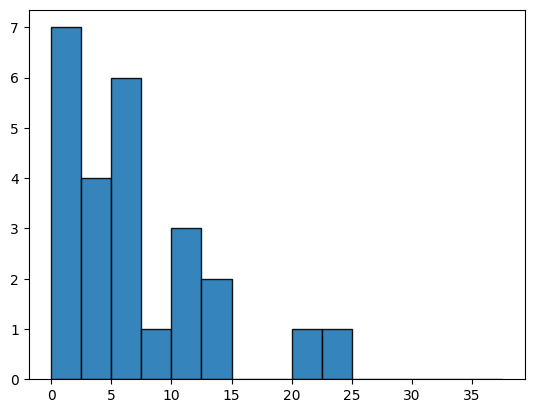

In [6]:
import spiegelib as spgl
import numpy as np

# Load the sound targets used for sound matching
targets = spgl.AudioBuffer.load_folder('./evaluation/audio')

# Load all the estimations of the sound targets made by each estimator
estimations = [
                # spgl.AudioBuffer.load_folder('./evaluation/mlp'),
                # spgl.AudioBuffer.load_folder('./evaluation/lstm'),
                # spgl.AudioBuffer.load_folder('./evaluation/bi_lstm'),
                # spgl.AudioBuffer.load_folder('./evaluation/cnn'),
                # spgl.AudioBuffer.load_folder('./evaluation/ga'),
                spgl.AudioBuffer.load_folder('./evaluation/nsga')]

# Evaluate the results and save to JSON file
evaluation = spgl.evaluation.MFCCEval(targets, estimations)
evaluation.evaluate()
evaluation.save_stats_json('./evaluation/evaluation_stats.json')

bins = np.arange(0, 40, 2.5)
evaluation.plot_hist([0], 'mean_abs_error', bins)
# evaluation.plot_hist([1], 'mean_abs_error', bins)

In [4]:
# now, create synth, generate dataset and train for genetic model using 4 operators

import dawdreamer as daw
from scipy.io import wavfile

import tensorflow as tf
import keras.api._v2.keras as keras
import keras.layers as layers

import random
import os.path

save_path = 'C:/FYP/ml-fm/wavs/'

SAMPLE_RATE = 44100
BUFFER_SIZE = 128
DURATION = 3 # overall duration of each audio file in seconds. This limits the range of attack values that will have an effect on the 
NOTE_DURATION = 2 # duration of midi note on message
START = 0

OUTPUT_PARAMS = 10

SYNTH_PLUGIN = "C:/FYP/vst2 dexed/Dexed.dll"

#import local edited version of spiegelib

from pathlib import Path
import sys

path_root = os.path.abspath('')
sys.path.append(str(path_root))
print(sys.path)

import spiegelib as spgl

['c:\\FYP\\ml-fm', 'c:\\Users\\Max\\miniconda3\\envs\\tf\\python39.zip', 'c:\\Users\\Max\\miniconda3\\envs\\tf\\DLLs', 'c:\\Users\\Max\\miniconda3\\envs\\tf\\lib', 'c:\\Users\\Max\\miniconda3\\envs\\tf', '', 'C:\\Users\\Max\\AppData\\Roaming\\Python\\Python39\\site-packages', 'C:\\Users\\Max\\AppData\\Roaming\\Python\\Python39\\site-packages\\win32', 'C:\\Users\\Max\\AppData\\Roaming\\Python\\Python39\\site-packages\\win32\\lib', 'C:\\Users\\Max\\AppData\\Roaming\\Python\\Python39\\site-packages\\Pythonwin', 'c:\\Users\\Max\\miniconda3\\envs\\tf\\lib\\site-packages', 'c:\\Users\\Max\\miniconda3\\envs\\tf\\lib\\site-packages\\win32', 'c:\\Users\\Max\\miniconda3\\envs\\tf\\lib\\site-packages\\win32\\lib', 'c:\\Users\\Max\\miniconda3\\envs\\tf\\lib\\site-packages\\Pythonwin', 'c:\\FYP\\ml-fm', 'c:\\FYP\\ml-fm', 'c:\\FYP\\ml-fm']


In [17]:
# spiegelib synth configuration

SYNTH_PLUGIN = "C:/FYP/vst2 dexed/Dexed.dll"

synth = spgl.synth.SynthVST(SYNTH_PLUGIN, sample_rate=SAMPLE_RATE)

# synth.save_state("./synth_params/dexed_simple_fm_init.json")

# select the algorithm number and convert to fit format
algorithm_number = 16
alg = (1.0 / 32.0) * float(algorithm_number - 1) + 0.001

# override the overall parameters and pitch modulation parameters
overridden_parameters = [
    (0, 1.0), # Filter Cutoff (Fully open)
    (1, 0.0), # Filter Resonance
    (2, 1.0), # Output Gain
    (3, 0.5), # Master Tuning (Center is 0)
    (4, alg), # Operator configuration
    (5, 0.0), # Feedback
    (6, 1.0), # Key Sync Oscillators
    (7, 0.35353535413742065), # LFO Speed
    (8, 0.0), # LFO Delay
    (9, 0.0), # LFO Pitch Modulation Depth
    (10, 0.0),# LFO Amplitude Modulation Depth
    (11, 1.0),# LFO Key Sync
    (12, 0.0),# LFO Waveform
    (13, 0.5),# Middle C Tuning
    (14, 0.4285714328289032),# P Mode Sens
    (15, 1.0),# Pitch EG rate
    (16, 1.0),# Pitch EG rate
    (17, 1.0),# Pitch EG rate
    (18, 1.0),# Pitch EG rate
    (19, 0.5050504803657532),# Pitch EG level
    (20, 0.5050504803657532),# Pitch EG level
    (21, 0.5050504803657532),# Pitch EG level
    (22, 0.5050504803657532),# Pitch EG level
]

# Turn Operator 1 into a simple sine wave with fixed volume and tuning, variable release
overridden_parameters.extend([
    (23, 0.9), # Operator 1 Attack Rate
    (24, 0.9), # Operator 1 Decay Rate
    (25, 0.9), # Operator 1 Sustain Rate
    # (26, 0.9), # Operator 1 Release Rate
    (27, 1.0), # Operator 1 Attack Level
    (28, 1.0), # Operator 1 Decay Level
    (29, 1.0), # Operator 1 Sustain Level
    (30, 0.0), # Operator 1 Release Level
    (31, 1.0), # Operator 1 Gain
    (32, 0.0), # Operator 1 Mode (1.0 is Fixed Frequency)
    (33, 0.5), # Operator 1 Coarse Tuning
    (34, 0.0), # Operator 1 Fine Tuning
    (35, 0.5), # Operator 1 Detune
    (36, 0.0), # Operator 1 Env Scaling Param
    (37, 0.0), # Operator 1 Env Scaling Param
    (38, 0.0), # Operator 1 Env Scaling Param
    (39, 0.0), # Operator 1 Env Scaling Param
    (40, 0.0), # Operator 1 Env Scaling Param
    (41, 0.0), # Operator 1 Env Scaling Param
    (42, 0.0), # Operator 1 Mod Sensitivity
    (43, 0.0), # Operator 1 Key Velocity
    (44, 1.0), # Operator 1 On/Off switch
])

# Override some of Operator 2 parameters
overridden_parameters.extend([
    (45, 0.9), # Operator 2 Attack Rate
    (49, 1.0), # Operator 2 Attack Level
    (54, 0.0), # Operator 2 Mode (1.0 is Fixed Frequency)
    (58, 0.0), # Operator 2 Env Scaling Param
    (59, 0.0), # Operator 2 Env Scaling Param
    (60, 0.0), # Operator 2 Env Scaling Param
    (61, 0.0), # Operator 2 Env Scaling Param
    (62, 0.0), # Operator 2 Env Scaling Param
    (63, 0.0), # Operator 2 Env Scaling Param
    (64, 0.0), # Operator 2 Mod Sensitivity
    (65, 0.0), # Operator 2 Key Velocity
    (66, 1.0), # Operator 2 On/Off switch
])

# Override some of Operator 3 parameters
overridden_parameters.extend([
    (67, 0.9), # Operator 3 Attack Rate
    (71, 1.0), # Operator 3 Attack Level
    (76, 0.0), # Operator 3 Mode (1.0 is Fixed Frequency)
    (80, 0.0), # Operator 3 Env Scaling Param
    (81, 0.0), # Operator 3 Env Scaling Param
    (82, 0.0), # Operator 3 Env Scaling Param
    (83, 0.0), # Operator 3 Env Scaling Param
    (84, 0.0), # Operator 3 Env Scaling Param
    (85, 0.0), # Operator 3 Env Scaling Param
    (86, 0.0), # Operator 3 Mod Sensitivity
    (87, 0.0), # Operator 3 Key Velocity
    (88, 1.0), # Operator 3 On/Off switch
])

# Override some of Operator 4 parameters
overridden_parameters.extend([
    (89, 0.9), # Operator 4 Attack Rate
    (93, 1.0), # Operator 4 Attack Level
    (98, 0.0), # Operator 4 Mode (1.0 is Fixed Frequency)
    (102, 0.0), # Operator 4 Env Scaling Param
    (103, 0.0), # Operator 4 Env Scaling Param
    (104, 0.0), # Operator 4 Env Scaling Param
    (105, 0.0), # Operator 4 Env Scaling Param
    (106, 0.0), # Operator 4 Env Scaling Param
    (107, 0.0), # Operator 4 Env Scaling Param
    (108, 0.0), # Operator 4 Mod Sensitivity
    (109, 0.0), # Operator 4 Key Velocity
    (110, 1.0), # Operator 4 On/Off switch
])

# Override operators 3 through 6
overridden_parameters.extend([(i, 0.0) for i in range(111, 155)])

# Set overridden parameters in synth
synth.set_overridden_parameters(overridden_parameters)

synth.save_state("./synth_params/dexed_simple_4op.json")

In [18]:
# create synth

synth = spgl.synth.SynthVST(SYNTH_PLUGIN,
                            note_length_secs=NOTE_DURATION,
                            render_length_secs=DURATION,
                            sample_rate=SAMPLE_RATE)
synth.load_state('./synth_params/dexed_simple_4op.json')

In [19]:
# create evalutation dataset
EVAL_NUM = 25

features = spgl.features.STFT(fft_size=512, hop_size=256, output='magnitude', time_major=True, sample_rate=SAMPLE_RATE)
eval_generator = spgl.DatasetGenerator(synth, features,
                                       output_folder='./evaluation4op',
                                       save_audio=True)
eval_generator.generate(EVAL_NUM)

Generating Dataset:   0%|          | 0/25 [00:00<?, ?it/s]

Generating Dataset: 100%|██████████| 25/25 [00:00<00:00, 48.73it/s]


In [21]:
# create non-dominated sorting genetic algorithm

# Load synth with overridden params
synth = spgl.synth.SynthVST(SYNTH_PLUGIN,
                            note_length_secs=NOTE_DURATION,
                            render_length_secs=DURATION,
                            sample_rate=SAMPLE_RATE)
synth.load_state('./synth_params/dexed_simple_4op.json')

# Feature extractors for Multi-Objective GA
nsga_extractors = [
                   spgl.features.MFCC(num_mfccs=13, hop_size=1024, sample_rate=SAMPLE_RATE),
                   spgl.features.SpectralSummarized(hop_size=1024, sample_rate=SAMPLE_RATE),
                   spgl.features.FFT(output='magnitude', sample_rate=SAMPLE_RATE)
                   ]

# NSGA3 Multi-Objective Genetic Algorithm
nsga = spgl.estimator.NSGA3(synth=synth, features=nsga_extractors)

# Sound matching helper class
nsga_matcher = spgl.SoundMatch(synth=synth, estimator=nsga)

targets = spgl.AudioBuffer.load_folder('./evaluation4op/audio')

for i in range(len(targets)):
    audio = nsga_matcher.match(targets[i])
    audio.save('./evaluation4op/nsga/nsga_prediction_%s.wav' % i)

c:\Users\Max\miniconda3\envs\tf\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\Max\miniconda3\envs\tf\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
Generation 25: 100%|██████████| 25/25 [04:08<00:00,  9.95s/it]


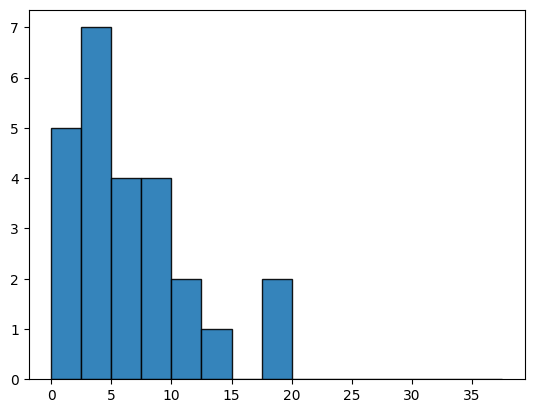

In [22]:
import spiegelib as spgl
import numpy as np

# Load the sound targets used for sound matching
targets = spgl.AudioBuffer.load_folder('./evaluation4op/audio')

# Load all the estimations of the sound targets made by each estimator
estimations = [spgl.AudioBuffer.load_folder('./evaluation4op/nsga')]

# Evaluate the results and save to JSON file
evaluation = spgl.evaluation.MFCCEval(targets, estimations)
evaluation.evaluate()
evaluation.save_stats_json('./evaluation4op/evaluation_stats.json')

bins = np.arange(0, 40, 2.5)
evaluation.plot_hist([0], 'mean_abs_error', bins)

In [23]:
# spiegelib synth configuration with more unlocked envelope params

# now, create synth, generate dataset and train for genetic model using 4 operators

import dawdreamer as daw
from scipy.io import wavfile

import tensorflow as tf
import keras.api._v2.keras as keras
import keras.layers as layers

import random
import os.path

save_path = 'C:/FYP/ml-fm/wavs/'

SAMPLE_RATE = 44100
BUFFER_SIZE = 128
DURATION = 4 # overall duration of each audio file in seconds. This limits the range of attack values that will have an effect on the 
NOTE_DURATION = 3 # duration of midi note on message
START = 0

OUTPUT_PARAMS = 10

SYNTH_PLUGIN = "C:/FYP/vst2 dexed/Dexed.dll"

#import local edited version of spiegelib

from pathlib import Path
import sys

path_root = os.path.abspath('')
sys.path.append(str(path_root))
print(sys.path)

import spiegelib as spgl

SYNTH_PLUGIN = "C:/FYP/vst2 dexed/Dexed.dll"

synth = spgl.synth.SynthVST(SYNTH_PLUGIN, sample_rate=SAMPLE_RATE)

# select the algorithm number and convert to fit format
algorithm_number = 16
alg = (1.0 / 32.0) * float(algorithm_number - 1) + 0.001

# override the overall parameters and pitch modulation parameters
overridden_parameters = [
    (0, 1.0), # Filter Cutoff (Fully open)
    (1, 0.0), # Filter Resonance
    (2, 1.0), # Output Gain
    (3, 0.5), # Master Tuning (Center is 0)
    (4, alg), # Operator configuration
    (5, 0.0), # Feedback
    (6, 1.0), # Key Sync Oscillators
    (7, 0.35353535413742065), # LFO Speed
    (8, 0.0), # LFO Delay
    (9, 0.0), # LFO Pitch Modulation Depth
    (10, 0.0),# LFO Amplitude Modulation Depth
    (11, 1.0),# LFO Key Sync
    (12, 0.0),# LFO Waveform
    (13, 0.5),# Middle C Tuning
    (14, 0.4285714328289032),# P Mode Sens
    (15, 1.0),# Pitch EG rate
    (16, 1.0),# Pitch EG rate
    (17, 1.0),# Pitch EG rate
    (18, 1.0),# Pitch EG rate
    (19, 0.5050504803657532),# Pitch EG level
    (20, 0.5050504803657532),# Pitch EG level
    (21, 0.5050504803657532),# Pitch EG level
    (22, 0.5050504803657532),# Pitch EG level
]

# Turn Operator 1
overridden_parameters.extend([
    (31, 1.0), # Operator 1 Gain
    (32, 0.0), # Operator 1 Mode (1.0 is Fixed Frequency)
    (33, 0.5), # Operator 1 Coarse Tuning
    (34, 0.0), # Operator 1 Fine Tuning
    (35, 0.5), # Operator 1 Detune
    (36, 0.0), # Operator 1 Env Scaling Param
    (37, 0.0), # Operator 1 Env Scaling Param
    (38, 0.0), # Operator 1 Env Scaling Param
    (39, 0.0), # Operator 1 Env Scaling Param
    (40, 0.0), # Operator 1 Env Scaling Param
    (41, 0.0), # Operator 1 Env Scaling Param
    (42, 0.0), # Operator 1 Mod Sensitivity
    (43, 0.0), # Operator 1 Key Velocity
    (44, 1.0), # Operator 1 On/Off switch
])

# Override some of Operator 2 parameters
overridden_parameters.extend([
    (54, 0.0), # Operator 2 Mode (1.0 is Fixed Frequency)
    (58, 0.0), # Operator 2 Env Scaling Param
    (59, 0.0), # Operator 2 Env Scaling Param
    (60, 0.0), # Operator 2 Env Scaling Param
    (61, 0.0), # Operator 2 Env Scaling Param
    (62, 0.0), # Operator 2 Env Scaling Param
    (63, 0.0), # Operator 2 Env Scaling Param
    (64, 0.0), # Operator 2 Mod Sensitivity
    (65, 0.0), # Operator 2 Key Velocity
    (66, 1.0), # Operator 2 On/Off switch
])

# Override some of Operator 3 parameters
overridden_parameters.extend([
    (76, 0.0), # Operator 3 Mode (1.0 is Fixed Frequency)
    (80, 0.0), # Operator 3 Env Scaling Param
    (81, 0.0), # Operator 3 Env Scaling Param
    (82, 0.0), # Operator 3 Env Scaling Param
    (83, 0.0), # Operator 3 Env Scaling Param
    (84, 0.0), # Operator 3 Env Scaling Param
    (85, 0.0), # Operator 3 Env Scaling Param
    (86, 0.0), # Operator 3 Mod Sensitivity
    (87, 0.0), # Operator 3 Key Velocity
    (88, 1.0), # Operator 3 On/Off switch
])

# Override some of Operator 4 parameters
overridden_parameters.extend([
    (98, 0.0), # Operator 4 Mode (1.0 is Fixed Frequency)
    (102, 0.0), # Operator 4 Env Scaling Param
    (103, 0.0), # Operator 4 Env Scaling Param
    (104, 0.0), # Operator 4 Env Scaling Param
    (105, 0.0), # Operator 4 Env Scaling Param
    (106, 0.0), # Operator 4 Env Scaling Param
    (107, 0.0), # Operator 4 Env Scaling Param
    (108, 0.0), # Operator 4 Mod Sensitivity
    (109, 0.0), # Operator 4 Key Velocity
    (110, 1.0), # Operator 4 On/Off switch
])

# Override operators 5 and  6
overridden_parameters.extend([(i, 0.0) for i in range(111, 155)])

# Set overridden parameters in synth
synth.set_overridden_parameters(overridden_parameters)

synth.save_state("./synth_params/dexed_simple_4op_env.json")


['c:\\FYP\\ml-fm', 'c:\\Users\\Max\\miniconda3\\envs\\tf\\python39.zip', 'c:\\Users\\Max\\miniconda3\\envs\\tf\\DLLs', 'c:\\Users\\Max\\miniconda3\\envs\\tf\\lib', 'c:\\Users\\Max\\miniconda3\\envs\\tf', '', 'C:\\Users\\Max\\AppData\\Roaming\\Python\\Python39\\site-packages', 'C:\\Users\\Max\\AppData\\Roaming\\Python\\Python39\\site-packages\\win32', 'C:\\Users\\Max\\AppData\\Roaming\\Python\\Python39\\site-packages\\win32\\lib', 'C:\\Users\\Max\\AppData\\Roaming\\Python\\Python39\\site-packages\\Pythonwin', 'c:\\Users\\Max\\miniconda3\\envs\\tf\\lib\\site-packages', 'c:\\Users\\Max\\miniconda3\\envs\\tf\\lib\\site-packages\\win32', 'c:\\Users\\Max\\miniconda3\\envs\\tf\\lib\\site-packages\\win32\\lib', 'c:\\Users\\Max\\miniconda3\\envs\\tf\\lib\\site-packages\\Pythonwin', 'c:\\FYP\\ml-fm', 'c:\\FYP\\ml-fm', 'c:\\FYP\\ml-fm', 'c:\\FYP\\ml-fm']


In [24]:
# create synth
synth = spgl.synth.SynthVST(SYNTH_PLUGIN,
                            note_length_secs=NOTE_DURATION,
                            render_length_secs=DURATION,
                            sample_rate=SAMPLE_RATE)
synth.load_state('./synth_params/dexed_simple_4op_env.json')

# create evalutation dataset
EVAL_NUM = 25

features = spgl.features.STFT(fft_size=512, hop_size=256, output='magnitude', time_major=True, sample_rate=SAMPLE_RATE)
eval_generator = spgl.DatasetGenerator(synth, features,
                                       output_folder='./evaluation_4op_env',
                                       save_audio=True)
eval_generator.generate(EVAL_NUM)

Generating Dataset: 100%|██████████| 25/25 [00:00<00:00, 40.52it/s]


In [25]:
# create non-dominated sorting genetic algorithm

# Load synth with overridden params
synth = spgl.synth.SynthVST(SYNTH_PLUGIN,
                            note_length_secs=NOTE_DURATION,
                            render_length_secs=DURATION,
                            sample_rate=SAMPLE_RATE)
synth.load_state('./synth_params/dexed_simple_4op_env.json')

# Feature extractors for Multi-Objective GA
nsga_extractors = [
                   spgl.features.MFCC(num_mfccs=13, hop_size=1024, sample_rate=SAMPLE_RATE),
                   spgl.features.SpectralSummarized(hop_size=1024, sample_rate=SAMPLE_RATE),
                   spgl.features.FFT(output='magnitude', sample_rate=SAMPLE_RATE)
                   ]

# NSGA3 Multi-Objective Genetic Algorithm
nsga = spgl.estimator.NSGA3(synth=synth, features=nsga_extractors)

# Sound matching helper class
nsga_matcher = spgl.SoundMatch(synth=synth, estimator=nsga)

targets = spgl.AudioBuffer.load_folder('./evaluation_4op_env/audio')

for i in range(len(targets)):
    audio = nsga_matcher.match(targets[i])
    audio.save('./evaluation_4op_env/nsga/nsga_prediction_%s.wav' % i)

Generation 25: 100%|██████████| 25/25 [05:31<00:00, 13.27s/it]


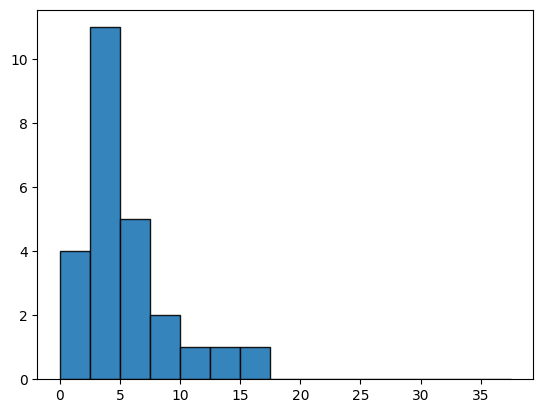

In [26]:
import spiegelib as spgl
import numpy as np

# Load the sound targets used for sound matching
targets = spgl.AudioBuffer.load_folder('./evaluation_4op_env/audio')

# Load all the estimations of the sound targets made by each estimator
estimations = [spgl.AudioBuffer.load_folder('./evaluation_4op_env/nsga')]

# Evaluate the results and save to JSON file
evaluation = spgl.evaluation.MFCCEval(targets, estimations)
evaluation.evaluate()
evaluation.save_stats_json('./evaluation_4op_env/evaluation_stats.json')

bins = np.arange(0, 40, 2.5)
evaluation.plot_hist([0], 'mean_abs_error', bins)

['c:\\FYP\\ml-fm', 'c:\\Users\\Max\\miniconda3\\envs\\tf\\python39.zip', 'c:\\Users\\Max\\miniconda3\\envs\\tf\\DLLs', 'c:\\Users\\Max\\miniconda3\\envs\\tf\\lib', 'c:\\Users\\Max\\miniconda3\\envs\\tf', '', 'C:\\Users\\Max\\AppData\\Roaming\\Python\\Python39\\site-packages', 'C:\\Users\\Max\\AppData\\Roaming\\Python\\Python39\\site-packages\\win32', 'C:\\Users\\Max\\AppData\\Roaming\\Python\\Python39\\site-packages\\win32\\lib', 'C:\\Users\\Max\\AppData\\Roaming\\Python\\Python39\\site-packages\\Pythonwin', 'c:\\Users\\Max\\miniconda3\\envs\\tf\\lib\\site-packages', 'c:\\Users\\Max\\miniconda3\\envs\\tf\\lib\\site-packages\\win32', 'c:\\Users\\Max\\miniconda3\\envs\\tf\\lib\\site-packages\\win32\\lib', 'c:\\Users\\Max\\miniconda3\\envs\\tf\\lib\\site-packages\\Pythonwin', 'c:\\FYP\\ml-fm', 'c:\\FYP\\ml-fm', 'c:\\FYP\\ml-fm', 'c:\\FYP\\ml-fm', 'c:\\FYP\\ml-fm']


Generation 25: 100%|██████████| 25/25 [03:59<00:00,  9.59s/it]


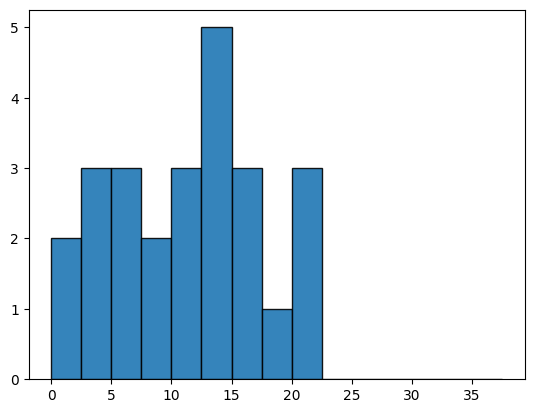

In [27]:
# spiegelib synth configuration with all 6 operators, no attack

import dawdreamer as daw
from scipy.io import wavfile

import tensorflow as tf
import keras.api._v2.keras as keras
import keras.layers as layers

import random
import os.path

save_path = 'C:/FYP/ml-fm/wavs/'

SAMPLE_RATE = 44100
BUFFER_SIZE = 128
DURATION = 3 # overall duration of each audio file in seconds. This limits the range of attack values that will have an effect on the 
NOTE_DURATION = 2 # duration of midi note on message
START = 0

SYNTH_PLUGIN = "C:/FYP/vst2 dexed/Dexed.dll"

#import local edited version of spiegelib

from pathlib import Path
import sys

path_root = os.path.abspath('')
sys.path.append(str(path_root))
print(sys.path)

import spiegelib as spgl

SYNTH_PLUGIN = "C:/FYP/vst2 dexed/Dexed.dll"

synth = spgl.synth.SynthVST(SYNTH_PLUGIN, sample_rate=SAMPLE_RATE)

# select the algorithm number and convert to fit format
algorithm_number = 16
alg = (1.0 / 32.0) * float(algorithm_number - 1) + 0.001

# override the overall parameters and pitch modulation parameters
overridden_parameters = [
    (0, 1.0), # Filter Cutoff (Fully open)
    (1, 0.0), # Filter Resonance
    (2, 1.0), # Output Gain
    (3, 0.5), # Master Tuning (Center is 0)
    (4, alg), # Operator configuration
    # (5, 0.0), # Feedback
    (6, 1.0), # Key Sync Oscillators
    (7, 0.35353535413742065), # LFO Speed
    (8, 0.0), # LFO Delay
    (9, 0.0), # LFO Pitch Modulation Depth
    (10, 0.0),# LFO Amplitude Modulation Depth
    (11, 1.0),# LFO Key Sync
    (12, 0.0),# LFO Waveform
    (13, 0.5),# Middle C Tuning
    (14, 0.4285714328289032),# P Mode Sens
    (15, 1.0),# Pitch EG rate
    (16, 1.0),# Pitch EG rate
    (17, 1.0),# Pitch EG rate
    (18, 1.0),# Pitch EG rate
    (19, 0.5050504803657532),# Pitch EG level
    (20, 0.5050504803657532),# Pitch EG level
    (21, 0.5050504803657532),# Pitch EG level
    (22, 0.5050504803657532),# Pitch EG level
]

# Turn Operator 1
overridden_parameters.extend([
    (23, 0.9), # Attack Rate
    (27, 1.0), # Attack Level
    (31, 1.0), # Operator 1 Gain
    (32, 0.0), # Operator 1 Mode (1.0 is Fixed Frequency)
    (33, 0.5), # Operator 1 Coarse Tuning
    (34, 0.0), # Operator 1 Fine Tuning
    (35, 0.5), # Operator 1 Detune
    (36, 0.0), # Operator 1 Env Scaling Param
    (37, 0.0), # Operator 1 Env Scaling Param
    (38, 0.0), # Operator 1 Env Scaling Param
    (39, 0.0), # Operator 1 Env Scaling Param
    (40, 0.0), # Operator 1 Env Scaling Param
    (41, 0.0), # Operator 1 Env Scaling Param
    (42, 0.0), # Operator 1 Mod Sensitivity
    (43, 0.0), # Operator 1 Key Velocity
    (44, 1.0), # Operator 1 On/Off switch
])

# Override some of Operator 2 parameters
overridden_parameters.extend([
    (45, 0.9), # Attack Rate
    (49, 1.0), # Attack Level
    (54, 0.0), # Operator 2 Mode (1.0 is Fixed Frequency)
    (58, 0.0), # Operator 2 Env Scaling Param
    (59, 0.0), # Operator 2 Env Scaling Param
    (60, 0.0), # Operator 2 Env Scaling Param
    (61, 0.0), # Operator 2 Env Scaling Param
    (62, 0.0), # Operator 2 Env Scaling Param
    (63, 0.0), # Operator 2 Env Scaling Param
    (64, 0.0), # Operator 2 Mod Sensitivity
    (65, 0.0), # Operator 2 Key Velocity
    (66, 1.0), # Operator 2 On/Off switch
])

# Override some of Operator 3 parameters
overridden_parameters.extend([
    (67, 0.9), # Attack Rate
    (71, 1.0), # Attack Level
    (76, 0.0), # Operator 3 Mode (1.0 is Fixed Frequency)
    (80, 0.0), # Operator 3 Env Scaling Param
    (81, 0.0), # Operator 3 Env Scaling Param
    (82, 0.0), # Operator 3 Env Scaling Param
    (83, 0.0), # Operator 3 Env Scaling Param
    (84, 0.0), # Operator 3 Env Scaling Param
    (85, 0.0), # Operator 3 Env Scaling Param
    (86, 0.0), # Operator 3 Mod Sensitivity
    (87, 0.0), # Operator 3 Key Velocity
    (88, 1.0), # Operator 3 On/Off switch
])

# Override some of Operator 4 parameters
overridden_parameters.extend([
    (89, 0.9), # Attack Rate
    (93, 1.0), # Attack Level
    (98, 0.0), # Operator 4 Mode (1.0 is Fixed Frequency)
    (102, 0.0), # Operator 4 Env Scaling Param
    (103, 0.0), # Operator 4 Env Scaling Param
    (104, 0.0), # Operator 4 Env Scaling Param
    (105, 0.0), # Operator 4 Env Scaling Param
    (106, 0.0), # Operator 4 Env Scaling Param
    (107, 0.0), # Operator 4 Env Scaling Param
    (108, 0.0), # Operator 4 Mod Sensitivity
    (109, 0.0), # Operator 4 Key Velocity
    (110, 1.0), # Operator 4 On/Off switch
])

# Override some of Operator 5 parameters
overridden_parameters.extend([
    (111, 0.9), # Attack Rate
    (115, 1.0), # Attack Level
    (120, 0.0), # Operator 5 Mode (1.0 is Fixed Frequency)
    (124, 0.0), # Operator 5 Env Scaling Param
    (125, 0.0), # Operator 5 Env Scaling Param
    (126, 0.0), # Operator 5 Env Scaling Param
    (127, 0.0), # Operator 5 Env Scaling Param
    (128, 0.0), # Operator 5 Env Scaling Param
    (129, 0.0), # Operator 5 Env Scaling Param
    (130, 0.0), # Operator 5 Mod Sensitivity
    (131, 0.0), # Operator 5 Key Velocity
    (132, 1.0), # Operator 5 On/Off switch
])

# Override some of Operator 6 parameters
overridden_parameters.extend([
    (133, 0.9), # Attack Rate
    (137, 1.0), # Attack Level
    (142, 0.0), # Operator 6 Mode (1.0 is Fixed Frequency)
    (146, 0.0), # Operator 6 Env Scaling Param
    (147, 0.0), # Operator 6 Env Scaling Param
    (148, 0.0), # Operator 6 Env Scaling Param
    (149, 0.0), # Operator 6 Env Scaling Param
    (150, 0.0), # Operator 6 Env Scaling Param
    (151, 0.0), # Operator 6 Env Scaling Param
    (152, 0.0), # Operator 6 Mod Sensitivity
    (153, 0.0), # Operator 6 Key Velocity
    (154, 1.0), # Operator 6 On/Off switch
])

# Set overridden parameters in synth
synth.set_overridden_parameters(overridden_parameters)

synth.save_state("./synth_params/dexed_simple_6op.json")


# create synth
synth = spgl.synth.SynthVST(SYNTH_PLUGIN,
                            note_length_secs=NOTE_DURATION,
                            render_length_secs=DURATION,
                            sample_rate=SAMPLE_RATE)
synth.load_state('./synth_params/dexed_simple_6op.json')

# create evalutation dataset
EVAL_NUM = 25

features = spgl.features.STFT(fft_size=512, hop_size=256, output='magnitude', time_major=True, sample_rate=SAMPLE_RATE)
eval_generator = spgl.DatasetGenerator(synth, features,
                                       output_folder='./evaluation_6op',
                                       save_audio=True)
eval_generator.generate(EVAL_NUM)

# create non-dominated sorting genetic algorithm

# Load synth with overridden params
synth = spgl.synth.SynthVST(SYNTH_PLUGIN,
                            note_length_secs=NOTE_DURATION,
                            render_length_secs=DURATION,
                            sample_rate=SAMPLE_RATE)
synth.load_state('./synth_params/dexed_simple_6op.json')

# Feature extractors for Multi-Objective GA
nsga_extractors = [
                   spgl.features.MFCC(num_mfccs=13, hop_size=1024, sample_rate=SAMPLE_RATE),
                   spgl.features.SpectralSummarized(hop_size=1024, sample_rate=SAMPLE_RATE),
                   spgl.features.FFT(output='magnitude', sample_rate=SAMPLE_RATE)
                   ]

# NSGA3 Multi-Objective Genetic Algorithm
nsga = spgl.estimator.NSGA3(synth=synth, features=nsga_extractors)

# Sound matching helper class
nsga_matcher = spgl.SoundMatch(synth=synth, estimator=nsga)

targets = spgl.AudioBuffer.load_folder('./evaluation_6op/audio')

for i in range(len(targets)):
    audio = nsga_matcher.match(targets[i])
    audio.save('./evaluation_6op/nsga/nsga_prediction_%s.wav' % i)

import spiegelib as spgl
import numpy as np

# Load the sound targets used for sound matching
targets = spgl.AudioBuffer.load_folder('./evaluation_6op/audio')

# Load all the estimations of the sound targets made by each estimator
estimations = [spgl.AudioBuffer.load_folder('./evaluation_6op/nsga')]

# Evaluate the results and save to JSON file
evaluation = spgl.evaluation.MFCCEval(targets, estimations)
evaluation.evaluate()
evaluation.save_stats_json('./evaluation_6op/evaluation_stats.json')

bins = np.arange(0, 40, 2.5)
evaluation.plot_hist([0], 'mean_abs_error', bins)